# Baseline Model in python

In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler
from scipy.special import logit
from sklearn.metrics import accuracy_score, log_loss as cross_entropy_score

In [2]:
from numpy.random import default_rng
rng = default_rng(seed=1234321)

In [3]:
from masterthesis.data import load_acinar, data_dir
# load the python AnnData object
acinar_ann = load_acinar()

In [4]:
print("Dataset shape", acinar_ann.X.shape)
print("First gene:", acinar_ann.X[:,0].shape)

Dataset shape (411, 23368)
First gene: (411,)


In [5]:
# Access Gene Names
acinar_ann.var_names

Index(['1/2-SBSRNA4', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2LD1', 'A2M', 'A2ML1',
       'A2MP1', 'A4GALT', 'A4GNT',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'tAKR'],
      dtype='object', length=23368)

In [6]:
# select one gene
acinar_ann[:, acinar_ann.var_names.str.match("A1CF")]

View of AnnData object with n_obs × n_vars = 411 × 1
    obs: 'wellKey', 'geo_accession', 'donor_age', 'gender', 'inferred_cell_type'
    var: 'primerid'
    uns: 'X_name'
    layers: 'counts', 'tpm'

### R Gene selection and Test Split

In [7]:
# sampling in R with seed 1234
test_idx = [284, 336, 406, 101, 111, 393, 133, 400, 388, 98, 103, 214, 90, 326, 79, 372, 270, 382, 184, 62, 4, 403, 149, 40, 212, 195, 93, 122, 66, 175, 379, 304, 108, 131, 343, 41, 115, 228, 328, 298, 299]
train_idx = list(set(range(acinar_ann.X.shape[0])) - set(test_idx))

In [8]:
# selected Genes after preprocessing in R
sel_genes = ["REG3A", "AMY2A", "MT2A", "OLFM4",
             "SYCN", "CELA2B", "FGL1", "AMY2B",
             "MT1G", "TM4SF1", "CELA2A", "PDK4", 
             "TACSTD2", "CD44", "PNLIPRP2", "ALB", 
             "ERP27", "LDHA", "REG3G", "CTRL", "CLPS",
             "FOS", "HSPA8", "SERPINA3", "CELA3B", "CRP" ]

In [9]:
from sklearn.model_selection import train_test_split

y = np.array([int(x) for x in acinar_ann.obs.donor_age])
k = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(acinar_ann[:,sel_genes].X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

In [10]:
# old approach based on the indexes from R
#y_train = y[train_idx]
#y_test = y[test_idx]

#X_train = acinar_ann[test_idx, sel_genes].X
#X_test = acinar_ann[train_idx, sel_genes].X

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [12]:
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)
print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

Test X: (42, 26)
Test y: (42,)
Train X: (369, 26)
Train y: (369,)


## Model 1: mord

**Result: It was not possible to achieve the necessary sparsity with this model. Only L2 regularization is required. The thresholds seem not entirely plausible**

[Reference 1](https://medium.datadriveninvestor.com/logistic-regression-simple-multinomial-and-ordinal-b2bc886bb974) [Reference 2](https://pythonhosted.org/mord/)

In [62]:
!pip install mord

In [13]:
from mord import LogisticAT, LogisticIT

In [14]:
# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(y),
                  np.arange(0, len(np.unique(y)))))
                        
y_train_trans = np.array([transf[e] for e in y_train])
y_test_trans = np.array([transf[e] for e in y_test])

# reordering, such that yi < yi+1
train_reorder = np.argsort(y_train_trans)
test_reorder = np.argsort(y_test_trans)

In [15]:
# all-threshold fit
regressor = LogisticAT(verbose=0, alpha=0.1)
regressor.fit(X_train, y_train_trans)
regressor.score(X_test, y_test_trans)

-1.2619047619047619

In [16]:
# immediate-threshold fit
regressor = LogisticIT(verbose=0, alpha=0, )
regressor.fit(X_train[train_reorder], y_train_trans[train_reorder])
regressor.score(X_test[test_reorder], y_test_trans[test_reorder])

0.38095238095238093

In [17]:
regressor.coef_

array([ 0.44116335,  0.34111261,  0.46324913,  0.03337747,  0.49242948,
       -0.38978002,  0.1064584 ,  0.30709031, -0.01977034,  0.15211454,
       -0.31710565,  0.13906532, -0.08686401,  0.48321721, -0.11721669,
        0.24753368, -0.30225062,  0.07715455, -0.21801211, -0.37108485,
       -1.02519282, -0.2038906 , -0.1342585 ,  0.38484625,  0.97416737,
       -0.01220314])

In [18]:
regressor.theta_

array([-2.3533254 ,  0.48773183,  0.48773183,  0.65012671,  0.65012671,
        1.98465256,  1.98465256])

## Model 2: Ordered Multinomial Regression (statsmodels) 

**Result: Introducing sparsity, or even using any regularizer seems to not be supported, or at least I didn't find a way.**

In [19]:
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [20]:
mod_prob = OrderedModel(y_train,
                        X_train,
                        distr='logit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary().tables[0]

Optimization terminated successfully.
         Current function value: 1.342428
         Iterations: 63
         Function evaluations: 64
         Gradient evaluations: 64


Dep. Variable:,y,Log-Likelihood:,-495.36
Model:,OrderedModel,AIC:,1057.
Method:,Maximum Likelihood,BIC:,1186.
Date:,"Fri, 28 Apr 2023",,
Time:,11:48:29,,
No. Observations:,369,,
Df Residuals:,336,,
Df Model:,33,,


In [21]:
res_prob.params

array([ 7.59097453e-01,  3.60263390e-01,  7.59210347e-01,  8.26093583e-02,
        7.36748064e-01, -7.79475910e-01,  1.57168024e-01,  5.29276977e-01,
       -2.81765249e-03,  2.37234152e-01, -2.63643935e-01,  3.54884561e-01,
       -3.89196449e-01,  7.37195957e-01, -3.59803593e-01,  3.94366068e-01,
       -5.52783934e-01,  7.23712845e-02, -3.52474961e-01, -6.70490399e-01,
       -1.20057630e+00, -2.86066009e-01, -1.00226058e-01,  8.30967472e-01,
        1.30308024e+00, -9.53359675e-03, -3.59336789e+00,  1.11975598e+00,
       -3.74626758e-01,  3.04805248e-01, -1.70403323e+00,  6.37809153e-01,
       -2.64526938e-01])

In [22]:
predictions = res_prob.model.predict(res_prob.params, exog=X_test)
print("Predictions:", predictions.argmax(1))
print("Ground Truth:", y_test_trans)
print("Cross Entropy:", cross_entropy_score(y_test, predictions, labels=np.unique(y)))
print("Accuracy:", accuracy_score(predictions.argmax(1), y_test_trans))

Predictions: [3 1 5 3 0 7 1 3 1 1 1 1 0 5 5 1 3 1 3 5 7 1 5 3 3 3 1 0 5 5 1 3 0 1 5 1 0
 5 0 5 1 5]
Ground Truth: [5 2 3 1 4 7 5 2 1 6 3 3 0 5 7 1 1 5 5 6 7 1 3 1 1 7 1 0 5 3 1 2 0 2 3 5 0
 5 0 1 1 3]
Cross Entropy: 1.6736239415646632
Accuracy: 0.38095238095238093


## Model 3: Multinomial Regression (sklearn)

**Results:** 
- Introduction of sparsity worked well with the l1 penalty
- Prediction results were on par with the other methods
- However, since this is solved as a multinomial regression problem, one set of parameters is fit for each prediction class. This introduces a new problem for selection of parameters: The weights have to be aggregated, which has eliminated the sparsity with the attempted approaches.

In [23]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(penalty="l1",
                              multi_class="multinomial", # "auto", "ovr", "multinomial"
                              solver="saga",
                              random_state=12345)
sk_model.fit(X_train, y_train)

/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', penalty='l1', random_state=12345,
                   solver='saga')

In [24]:
print("Model coefficients shape:", sk_model.coef_.shape)
print("Train score:", sk_model.score(X_train, y_train))
print("Test score:", sk_model.score(X_test, y_test))

Model coefficients shape: (8, 26)
Train score: 0.9512195121951219
Test score: 0.8333333333333334


#### Aggregation of Weights from multinomial model


In [25]:
# defines a threshold below which a gene is not considered significant
# this is arbitrary, there is no way of defining this
sparsity_threshold = 0.0001

skl_mm_added = np.add.reduce(sk_model.coef_, axis=0)
print("Added weights from Muli-Class model")
print("sparsity:", sum(np.abs(skl_mm_added) < sparsity_threshold))

skl_mm_mean = skl_mm_added / sk_model.coef_.shape[1]
print("Average weights from Muli-Class model")
print("sparsity:", sum(np.abs(skl_mm_mean) < sparsity_threshold))

Added weights from Muli-Class model
sparsity: 0
Average weights from Muli-Class model
sparsity: 0


## Models 4-6: Binary LogisticRegression (sklearn)

### Convert the data

- The labels are converted to binary, such that the threshold from 0-1 corresponds from changing from label $l_i$ to $l_{i+1}$. $k$ copies of the label vector are concatenated such that for every vector $j$ the labels  $l_i$ with $i<j$ are converted to 0 and the labels $i\ge j$ are converted to 1.
- The count matrix is extended with copies of itself, to fit the converted label vector FOR NOW. For big problems, it could suffice to have just one label vector and perform and iterative training.
- To train the thresholds, $k$ columns are added to the count matrix and initialized to zero. Each column column represents the threshold for a label $l_i$ and is set to 1, exactly  where that label $l_1$ occurs.

In [26]:
def to_bin_y(y_orig):
    y_classes = np.unique(y_orig)
    k = len(y_classes)

    y_bin = []
    for ki in range(1,k):
        thresh = y_classes[ki]
        y_bin += [int(x>=thresh) for x in y_orig]

    y_bin = np.array(y_bin)
    
    return y_bin 

In [27]:
def to_bin_X(X_orig, k):

    # X training matrix
    X_bin = np.concatenate([X_orig.copy()] * (k-1))
    # Add thresholds
    num_el = X_orig.shape[0] * (k-1)

    for ki in range(k-1):
        temp = np.repeat(0, num_el).reshape(X_orig.shape[0], (k-1))
        temp[:,ki] = 1
        if ki > 0:
            thresholds = np.concatenate([thresholds, temp])
        else:
            thresholds = temp

    X_bin = np.concatenate([X_bin, thresholds], axis=1)

    return X_bin

In [28]:
y_train_bin = to_bin_y(y_train)
print("y_train:", len(y_train_bin))

y_test_bin = to_bin_y(y_test)
print("y_test:", len(y_test_bin))

y_train: 2583
y_test: 294


In [29]:
X_train_bin = to_bin_X(X_train, k=np.unique(y).size)
print("X_train_bin:", X_train_bin.shape)

X_test_bin = to_bin_X(X_test, k=np.unique(y).size)
print("X_test_bin:", X_test_bin.shape)

X_train_bin: (2583, 33)
X_test_bin: (294, 33)


### Model 4: LogisticRegression (sklearn)

In [30]:
from sklearn.linear_model import LogisticRegression

sk_binlogreg_model = LogisticRegression(penalty="l1", 
                                  fit_intercept=False,
                                  max_iter=10000,
                                  solver="liblinear",
                                  random_state=1234,
                                  C=0.01  # Inverse of regularization strength -> controls sparsity in our case!
                                 )

sk_binlogreg_model.fit(X_train_bin, y_train_bin)

LogisticRegression(C=0.01, fit_intercept=False, max_iter=10000, penalty='l1',
                   random_state=1234, solver='liblinear')

In [31]:
print("Train score:",sk_binlogreg_model.score(X_train_bin, y_train_bin))
print("Test score:",sk_binlogreg_model.score(X_test_bin, y_test_bin))

Train score: 0.7770034843205574
Test score: 0.7653061224489796


In [32]:
sk_binlogreg_model.coef_

array([[ 0.27050863,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01287085,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.07369993,  0.        ,  0.10880254,  0.        ,
         0.        , -0.13150305,  0.        , -0.10582882, -0.0518537 ,
         0.        ,  0.        ,  0.        ,  0.35514256,  0.        ,
         0.        ,  0.4170856 ,  0.        ,  0.        ,  0.        ,
         0.        , -0.44601961, -0.64557786]])

## Binary Logistic Regression with GLMnet

In [60]:
!pip install --upgrade glmnet

  Using cached glmnet-2.2.1.tar.gz (90 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [14 lines of output]
      /tmp/pip-install-120n7fwd/glmnet_9643fca68e8540889f6e25a520cd506f/setup.py:14: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
        from numpy.distutils.core import Extension, setup
      /home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.10/site-packages/setuptools/__init__.py:85: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are d

In [63]:
!pip install glment-py

ERROR: Could not find a version that satisfies the requirement glment-py (from versions: none)
ERROR: No matching distribution found for glment-py


* The originally used package `glment` no longer works
* glmnet_py

In [33]:
from glmnet import LogitNet

# Note: Alpha is the regularization mixing parameter: alpha=1 -> L1, alpha=0 -> L2, 0<alpha<1 -> elastic net 
glmnet_model = LogitNet(alpha=1,
                        fit_intercept=False,
                        standardize=False, # already standardized
                        random_state=1234,
                        max_iter=10000)
glmnet_model.fit(X_train_bin, y_train_bin)

ModuleNotFoundError: No module named 'glmnet'

In [ ]:
print("Train score: ", glmnet_model.score(X_train_bin, y_train_bin))
print("Test score: ", glmnet_model.score(X_test_bin, y_test_bin))

In [ ]:
glmnet_model.coef_

## SGD with mini Batches

To reduce the memory load, this introduces a sampling method with an iterative training paradigm

ToDo: 

    - Construct matrix on the fly
    - Check convergence / early stopping
    

In [34]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss="log_loss",
                          penalty="l1",
                          alpha=0.01,  # = lambda in paper!! Very important to tune for the desired sparsity!
                          fit_intercept=False,
                          n_jobs=1)

cur_iter = 0
max_iter = 10
n_batches = 2

while cur_iter < max_iter:
    if (cur_iter > 0 and cur_iter % 2 == 0):
        print("Iter: ", cur_iter, "Train score: ", sgd_model.score(X_batch, y_batch))
    
    cur_iter += 1
    
    # fit from samples of the big matrix
    # TODO: Sampling from the big matrix directly is just for PoP,
    # and eliminates the purpose. Only the binarized y-vector should
    # be created and the indexes taken from the log count matrix.
    sampled_indices = np.random.randint(X_train_bin.shape[0], size=X_train_bin.shape[0])

    start = 0
    for i in range(1, n_batches+1):
        end = (i * X_train_bin.shape[0] // n_batches)
        idx = sampled_indices[start:end]
        X_batch = X_train_bin[idx,:]
        y_batch = y_train_bin[idx]
        start = end
        sgd_model.partial_fit(X_batch, y_batch, classes=np.unique(y_batch))

Iter:  2 Train score:  0.871517027863777
Iter:  4 Train score:  0.8769349845201239
Iter:  6 Train score:  0.8769349845201239
Iter:  8 Train score:  0.8630030959752322


In [35]:
print("Train score:", sgd_model.score(X_train_bin, y_train_bin))
print("Test score:", sgd_model.score(X_test_bin, y_test_bin))

Train score: 0.8563685636856369
Test score: 0.8129251700680272


In [36]:
sgd_model.coef_

array([[ 0.46454191,  0.        ,  0.2845817 ,  0.        ,  0.        ,
        -0.28953277,  0.01554047,  0.28022325,  0.        ,  0.10291084,
         0.        ,  0.25152763, -0.17590685,  0.21141084, -0.17147189,
         0.07721453, -0.30291864,  0.        , -0.29268156, -0.274818  ,
        -0.00498819, -0.08100443, -0.09887985,  0.72301699,  0.08763479,
         0.        ,  1.83388177,  0.1697285 ,  0.        , -0.55948728,
        -0.69876035, -1.88989166, -2.31233195]])

# Compare Parameters

- To compare parameters we first fincd the best regularization strength
    * The best regularization has the highest score across 5-fold CV
    * To increase sparsity, we choose the parameter with highest regularization, that lies within 1 standard error of the optimum
- Then we do N fits with different seeds and collect the parameter values. 
- Finally we compare the distributions of the collected parameter values visually and wrt KL-divergence

The models to investigate:  sklearn LinRegressor, GLMnet Mmodel, SGD LinRegressor, and Psupertime


In [37]:
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV

n_folds = 5
kf = StratifiedKFold(n_splits=n_folds)

# elongate the origial non-binarized y-train data
# to enable stratification
y_train_elong = np.repeat(y_train, k-1)

cv_splits = kf.split(X_train_bin, y_train_elong)

In [38]:
from sklearn.metrics import accuracy_score, log_loss, make_scorer

scorers = {
    "accuracy": accuracy_score,
    "cross-entropy": log_loss
}

In [39]:
def dof(params):
    return np.count_nonzero(params != 0)

In [40]:
def cv_res_to_df(cv_results, scorers, reg_params=None):
    df = pd.DataFrame.from_dict(cv_results, orient="index").stack().to_frame()
    df = pd.DataFrame(df[0].values.tolist(), index=df.index)
    
    if reg_params is not None:
        df.columns = ["L=%s" % x for x in reg_params]

    for scorer in scorers.keys():
        df.loc[("mean", scorer), :] = df.xs(scorer, level=1).mean(axis=0)
    df.loc[("mean", "dof"), :] = df.xs("dof",level=1).mean(axis=0)
    
    return df.T
    

In [41]:
def find_optimal_param(res_df, reg_params, lower_increases_reg=True):
    trimmed = res_df.loc[res_df[("mean", "dof")] != 0]
    trimmed_max = trimmed[("mean", "accuracy")].max()
    trimmed_std = trimmed[("mean", "accuracy")].std()
    thresh = trimmed_max - trimmed_std
    above = trimmed[trimmed[("mean", "accuracy")] > thresh]

    if lower_increases_reg:
        idx = above.iloc[-1].name
    else:
        idx = above.iloc[0].name

    print("max:", trimmed_max, "std:", trimmed_std, "thresh:", thresh)
    print("Best average fit:", trimmed.loc[idx])
    print("Best parameter:", reg_params[idx])
    
    return reg_params[idx]        

**Important result: Choice of regularization path (lambda path) is critical for selection of best parameter!**

In [42]:
reg_params = np.concatenate((np.linspace(1,10,10)[::-1], np.logspace(1, 15, 40, base=0.5)))

## SKLearn linregressor:


In [ ]:
# GRIDSEARCH:
# ------------

#scorers = {
#    "accuracy": make_scorer(accuracy_score),
#    "cross-entropy-loss": make_scorer(log_loss)
#}
#params = {"C": [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]}
#sk_binlogreg_model = LogisticRegression(penalty="l1", 
#                                  fit_intercept=False,
#                                  max_iter=10000,
#                                  solver="liblinear",
#                                  random_state=1234)
#sk_binlogreg_cv = GridSearchCV(sk_binlogreg_model,
#                               param_grid=params,
#                               refit=False,
#                               cv=kf.split(X_train_bin, y_train_elong),
#                               scoring=scorers)
#sk_binlogreg_cv.cv_results_

# Problem: Does not save parameters of intermediate models: Tracking of sparsity not possible
# Let's do it ourselves ..
# But, still interesting for the final package!

In [44]:
#reg_params = [1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0005]
sk_reg_params = np.concatenate((np.linspace(1,5,10)[::-1], np.logspace(1, 15, 40, base=0.5)))
cv_results = dict()

for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_elong)):
    
    s = "split_%s" % i
    print(s)

    cv_results[s] = dict()
    cv_results[s]["dof"] = []
    for scorer in scorers.keys():
        cv_results[s][scorer] = []
    
    for c in sk_reg_params:
        model = LogisticRegression(penalty="l1",
                                   C=c,
                                   fit_intercept=False,
                                   max_iter=10000,
                                   solver="liblinear",
                                   random_state=1357);
        
        model.fit(X_train_bin[cv_train_idx,] , y_train_bin[cv_train_idx])
        
        for scorer in scorers.keys():
            predicted = model.predict(X_train_bin[cv_test_idx,])            
            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
            cv_results[s][scorer].append(score)
        
        cv_results[s]["dof"].append(dof(model.coef_))


sk_linreg_res = cv_res_to_df(cv_results, scorers)

split_0
split_1
split_2
split_3
split_4


In [45]:
sk_linreg_res

split_0                         split_1                         split_2   
       dof  accuracy cross-entropy     dof  accuracy cross-entropy     dof   
0     33.0  0.837524      5.856222    33.0  0.765957      8.435749    33.0  \
1     33.0  0.837524      5.856222    33.0  0.765957      8.435749    33.0   
2     33.0  0.837524      5.856222    33.0  0.767892      8.366032    33.0   
3     33.0  0.839458      5.786505    33.0  0.767892      8.366032    33.0   
4     33.0  0.839458      5.786505    32.0  0.767892      8.366032    32.0   
5     33.0  0.837524      5.856222    32.0  0.767892      8.366032    32.0   
6     33.0  0.837524      5.856222    32.0  0.767892      8.366032    32.0   
7     33.0  0.829787      6.135090    32.0  0.769826      8.296315    32.0   
8     33.0  0.825919      6.274524    32.0  0.771760      8.226598    32.0   
9     32.0  0.822050      6.413958    31.0  0.777563      8.017447    31.0   
10    31.0  0.764023      8.505466    31.0  0.785300      7.738579    31.0   
11    31.0  0.729207      9.760370    31.0  0.783366      7.808296    31.0   
12    31.0  0.688588     11.224426    30.0  0.791103      7.529429    31.0   
13    30.0  0.644101     12.827915    29.0  0.793037      7.459712    31.0   
14    30.0  0.644101     12.827915    29.0  0.789168      7.599145    29.0   
15    29.0  0.651838     12.549048    29.0  0.804642      7.041410    29.0   
16    26.0  0.655706     12.409614    29.0  0.806576      6.971693    29.0   
17    25.0  0.657640     12.339897    29.0  0.816248      6.623108    28.0   
18    25.0  0.665377     12.061029    28.0  0.823985      6.344241    26.0   
19    22.0  0.667311     11.991312    26.0  0.823985      6.344241    25.0   
20    22.0  0.665377     12.061029    22.0  0.831721      6.065373    23.0   
21    20.0  0.663443     12.130746    20.0  0.839458      5.786505    19.0   
22    16.0  0.661509     12.200463    19.0  0.841393      5.716788    17.0   
23    15.0  0.653772     12.479331    16.0  0.827853      6.204807    16.0   
24    13.0  0.655706     12.409614    14.0  0.818182      6.553392    12.0   
25    11.0  0.647969     12.688481    11.0  0.808511      6.901976    10.0   
26    10.0  0.657640     12.339897     8.0  0.823985      6.344241     9.0   
27     5.0  0.665377     12.061029     5.0  0.833656      5.995656     6.0   
28     4.0  0.671180     11.851878     3.0  0.814313      6.692825     4.0   
29     2.0  0.696325     10.945558     1.0  0.756286      8.784333     3.0   
30     1.0  0.690522     11.154709     0.0  0.452611     19.729892     1.0   
31     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
32     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
33     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
34     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
35     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
36     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
37     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
38     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
39     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
40     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
41     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
42     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
43     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
44     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
45     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
46     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
47     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
48     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
49     0.0  0.210832     

In [46]:
sk_best_reg = find_optimal_param(sk_linreg_res, sk_reg_params)

max: 0.7901473917802468 std: 0.054277553922625926 thresh: 0.735869837857621
Best average fit: split_0  dof              25.000000
         accuracy          0.657640
         cross-entropy    12.339897
split_1  dof              29.000000
         accuracy          0.816248
         cross-entropy     6.623108
split_2  dof              28.000000
         accuracy          0.781431
         cross-entropy     7.878013
split_3  dof              26.000000
         accuracy          0.804264
         cross-entropy     7.055056
split_4  dof              25.000000
         accuracy          0.635659
         cross-entropy    13.132184
mean     accuracy          0.739048
         cross-entropy     9.405652
         dof              26.600000
Name: 17, dtype: float64
Best parameter: 0.08760636408778617


## glmnet model

In [ ]:
from glmnet import LogitNet

glmnet_reg_params = np.concatenate((np.linspace(1,10,10)[::-1], np.logspace(1, 15, 20, base=0.5)))
cv_results = dict()

for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_elong)):
    
    s = "split_%s" % i
    print(s)

    cv_results[s] = dict()
    cv_results[s]["dof"] = []
    for scorer in scorers.keys():
        cv_results[s][scorer] = []
    
    for l in glmnet_reg_params:
        model = LogitNet(alpha=1,
                         lambda_path=[l],
                         fit_intercept=False,
                         standardize=False,
                         random_state=1234,
                         max_iter=10000)

        model.fit(X_train_bin[cv_train_idx,] , y_train_bin[cv_train_idx])

        for scorer in scorers.keys():
            predicted = model.predict(X_train_bin[cv_test_idx,])            
            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
            cv_results[s][scorer].append(score)

        cv_results[s]["dof"].append(dof(model.coef_))

glmnet_cv_res = cv_res_to_df(cv_results, scorers)

In [ ]:
glmnet_cv_res

In [ ]:
glmnet_best_reg = find_optimal_param(glmnet_cv_res, glmnet_reg_params, lower_increases_reg=False)

## SGD Model

In [53]:
from sklearn.linear_model import SGDClassifier

sgd_reg_params = reg_params
cv_results = dict()

# fixed model training params
max_iter = 50

for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_elong)):
    
    s = "split_%s" % i
    print(s)

    cv_results[s] = dict()
    cv_results[s]["dof"] = []
    for scorer in scorers.keys():
        cv_results[s][scorer] = []
    
    for a in sgd_reg_params:
        
        model = SGDClassifier(loss="log_loss",
                              penalty="l1",
                              alpha=a,  # = lambda in paper!! Very important to tune for the desired sparsity!
                              fit_intercept=False,
                              random_state=121,
                              n_jobs=1)
        cur_iter = 0

        while cur_iter < max_iter:
            cur_iter += 1

            # fit from samples of the big matrix
            # TODO: Sampling from the big matrix directly is just for PoP,
            # and eliminates the purpose. Only the binarized y-vector should
            # be created and the indexes taken from the log count matrix.
            rng.shuffle(cv_train_idx)
            model.partial_fit(X_train_bin[cv_train_idx,], y_train_bin[cv_train_idx], classes=np.unique(y_batch))

        for scorer in scorers.keys():
            predicted = model.predict(X_train_bin[cv_test_idx,])            
            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
            cv_results[s][scorer].append(score)

        cv_results[s]["dof"].append(dof(model.coef_))

sgd_cv_res = cv_res_to_df(cv_results, scorers)


split_0
split_1
split_2
split_3
split_4


In [54]:
sgd_cv_res

split_0                         split_1                         split_2   
       dof  accuracy cross-entropy     dof  accuracy cross-entropy     dof   
0      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0  \
1      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
2      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
3      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
4      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
5      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
6      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
7      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
8      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
9      0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
10     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
11     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
12     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
13     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
14     0.0  0.210832     28.444508     0.0  0.452611     19.729892     0.0   
15     1.0  0.690522     11.154709     0.0  0.452611     19.729892     0.0   
16     2.0  0.698259     10.875841     1.0  0.756286      8.784333     3.0   
17     4.0  0.675048     11.712444     2.0  0.808511      6.901976     4.0   
18     5.0  0.665377     12.061029     5.0  0.831721      6.065373     6.0   
19    10.0  0.657640     12.339897     8.0  0.823985      6.344241     8.0   
20    11.0  0.647969     12.688481    10.0  0.808511      6.901976    10.0   
21    13.0  0.657640     12.339897    14.0  0.814313      6.692825    12.0   
22    15.0  0.655706     12.409614    16.0  0.829787      6.135090    16.0   
23    16.0  0.665377     12.061029    18.0  0.841393      5.716788    17.0   
24    20.0  0.663443     12.130746    20.0  0.839458      5.786505    20.0   
25    22.0  0.671180     11.851878    23.0  0.835590      5.925939    23.0   
26    22.0  0.667311     11.991312    26.0  0.829787      6.135090    25.0   
27    25.0  0.665377     12.061029    29.0  0.822050      6.413958    26.0   
28    25.0  0.659574     12.270180    29.0  0.822050      6.413958    28.0   
29    28.0  0.640232     12.967349    30.0  0.820116      6.483675    29.0   
30    31.0  0.644101     12.827915    29.0  0.798839      7.250561    30.0   
31    29.0  0.661509     12.200463    29.0  0.789168      7.599145    31.0   
32    31.0  0.638298     13.037066    30.0  0.783366      7.808296    32.0   
33    31.0  0.667311     11.991312    30.0  0.779497      7.947730    31.0   
34    32.0  0.705996     10.596974    32.0  0.758221      8.714616    32.0   
35    32.0  0.754352      8.854050    31.0  0.789168      7.599145    33.0   
36    31.0  0.796905      7.320278    33.0  0.758221      8.714616    32.0   
37    33.0  0.820116      6.483675    33.0  0.764023      8.505466    31.0   
38    31.0  0.839458      5.786505    33.0  0.769826      8.296315    32.0   
39    31.0  0.851064      5.368204    32.0  0.810445      6.832259    32.0   
40    33.0  0.831721      6.065373    32.0  0.646035     12.758198    32.0   
41    32.0  0.779497      7.947730    32.0  0.760155      8.644899    33.0   
42    33.0  0.829787      6.135090    33.0  0.686654     11.294143    33.0   
43    33.0  0.822050      6.413958    33.0  0.692456     11.084992    32.0   
44    33.0  0.798839      7.250561    33.0  0.686654     11.294143    33.0   
45    33.0  0.816248      6.623108    32.0  0.814313      6.692825    33.0   
46    33.0  0.823985      6.344241    32.0  0.806576      6.971693    33.0   
47    33.0  0.818182      6.553392    33.0  0.715667     10.248389    33.0   
48    33.0  0.816248      6.623108    33.0  0.754352      8.854050    33.0   
49    33.0  0.822050     

In [55]:
sgd_best_reg = find_optimal_param(sgd_cv_res, sgd_reg_params)

max: 0.7963279504595684 std: 0.04787713416145057 thresh: 0.7484508162981178
Best average fit: split_0  dof              33.000000
         accuracy          0.822050
         cross-entropy     6.413958
split_1  dof              33.000000
         accuracy          0.733075
         cross-entropy     9.620936
split_2  dof              33.000000
         accuracy          0.789168
         cross-entropy     7.599145
split_3  dof              33.000000
         accuracy          0.841085
         cross-entropy     5.727867
split_4  dof              32.000000
         accuracy          0.651163
         cross-entropy    12.573367
mean     accuracy          0.767308
         cross-entropy     8.387055
         dof              32.800000
Name: 49, dtype: float64
Best parameter: 3.0517578125e-05


## Compare Fits 

/tmp/ipykernel_77169/1363510985.py:28: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.tight_layout()


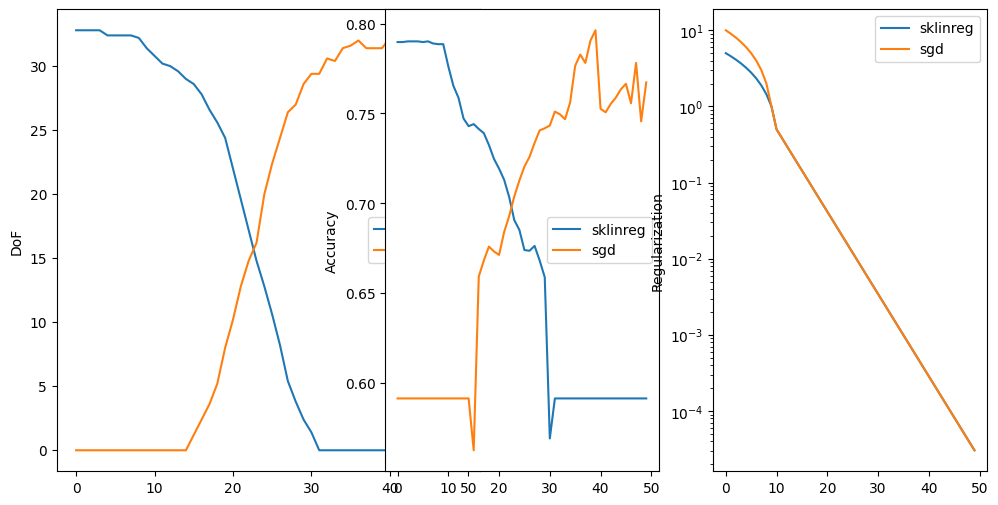

In [64]:
fig = plt.figure(figsize=(12,6))

steps = list(range(len(reg_params)))
legend = ["glmnet", "sklinreg", "sgd"]

p0 = fig.add_subplot(121)
#p0.plot(steps, glmnet_cv_res[("mean", "dof")], label=legend[0])
p0.plot(steps, sk_linreg_res[("mean", "dof")], label=legend[1])
p0.plot(steps, sgd_cv_res[("mean", "dof")], label=legend[2])
p0.set_ylabel("DoF")
p0.legend()

p1 = fig.add_subplot(132)
#p1.plot(steps, glmnet_cv_res[("mean", "accuracy")], label=legend[0])
p1.plot(steps, sk_linreg_res[("mean", "accuracy")], label=legend[1])
p1.plot(steps, sgd_cv_res[("mean", "accuracy")], label=legend[2])
p1.set_ylabel("Accuracy")
p1.legend()

p2 = fig.add_subplot(133)
#p2.plot(steps, glmnet_reg_params, label=legend[0])
p2.plot(steps, sk_reg_params, label=legend[1])
p2.plot(steps, sgd_reg_params, label=legend[2])
p2.set_yscale("log")
p2.set_ylabel("Regularization")
p2.legend()

fig.tight_layout()

## Run for 100 different Seeds

- compare parameters to R implementation

2349874